In [8]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,256,64,1]
costs=[]
dtype=torch.float
continue_flag=0
PATH='./checkpoint_onelayer'
w=[]
z=[]
rate_list=[]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']

else:
    for i in range(len(layer_num)-1):
    
        w.append(torch.randn(layer_num[i],layer_num[i+1], dtype=dtype, requires_grad=True,device="cuda"))

epoches=20
lamda=100
learning_rate=1
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        img=img.reshape(-1,layer_num[0]).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(torch.tanh(torch.mm(img,w[0]).cuda()).cuda())
        for cnt in range(len(w)-1):
            
            z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()).cuda())
            
        grad_list=[]
        
        for cnt in range(len(z)-1):

            
            cost=-emerinal_hsic(z[cnt],img)-lamda*emerinal_hsic(z[cnt],target)
        #print(cost1)
            cost.backward(retain_graph=True)
            #print('!')
        #print(w1.cuda().grad)
            with torch.no_grad():
                buf=torch.zeros((w[cnt].shape)).cuda()
                #print(buf.shape)
                buf.copy_(w[cnt].grad)
                
                grad_list.append(buf)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
                w[cnt].grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        entropy=emerinal_hsic(z[-1],img)
        information=lamda*emerinal_hsic(z[-1],target)
        rate=entropy/information
        cost=-entropy-information+0.05*(entropy/information)
        cost.backward()
        
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1] -= learning_rate * w[-1].grad
            
            for cnt in range(len(w)-1):
                w[cnt] -= learning_rate * grad_list[cnt]
        # Manually zero the gradients after updating weights
            w[-1].grad.zero_()
            
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            costs.append(cost)
            print(rate)
            rate_list.append(rate)
            print(i_batch)
            print('cost',cost)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

Populating the interactive namespace from numpy and matplotlib
tensor(0.0892, device='cuda:0', grad_fn=<DivBackward0>)
0
cost tensor(-1.0795, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.0887, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(0.9952, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0595, device='cuda:0', grad_fn=<DivBackward0>)
100
cost tensor(-3.5730, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.2007, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.3752, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0559, device='cuda:0', grad_fn=<DivBackward0>)
200
cost tensor(-3.3501, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.1775, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.1754, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0590, device='cuda:0', grad_fn=<DivBackward0>)
0
cost tensor(-3.5925, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(0.2004, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.3951, device='cu

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=1x1 at 0x7F08B6421B38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/PIL/Image.py", line 617, in __del__
KeyboardInterrupt
    self.fp = None


KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib
[[-0.99999946  1.          1.         -1.         -1.         -1.
   0.99872816 -1.          1.          0.9999974 ]
 [-1.          1.          0.9998784  -1.          1.         -1.
   0.99990976 -0.9999995   1.         -1.        ]
 [-0.99999976  1.          0.9999987  -1.          0.99914247 -1.
  -0.9896256  -0.99998206  0.99999183  1.        ]
 [ 1.         -1.         -1.          1.          1.          1.
  -1.          1.         -1.          1.        ]
 [ 1.         -1.         -1.          1.          1.          1.
  -1.          1.         -1.          0.99999005]
 [ 1.          0.9800576   0.9999899  -1.         -0.9620438   0.9999876
   0.9999931   0.9999477   0.99975735  1.        ]
 [ 1.          1.          1.         -1.         -1.          1.
   1.          1.          1.          1.        ]
 [ 1.         -1.         -0.9999999   1.          1.          1.
  -1.          1.         -1.          0.9999

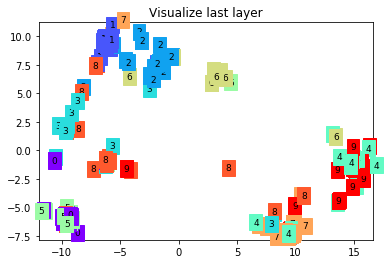

In [9]:

import torch
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    print(len(labels))
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
PATH='./checkpoint_onelayer'
checkpoint = torch.load(PATH)
data_tsne_label=np.array(checkpoint['data_tsne_label'])
data_tsne_rp=np.array(checkpoint['z'][0].cpu().data.numpy())
print(data_tsne_rp[:50,:],data_tsne_label[:50])

data_tsne_label=data_tsne_label.reshape((-1))
#print(data_tsne_label)
#data_tsne=np.array(data_tsne[:][])
if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
    plot_only = 255
    low_dim_embs = tsne.fit_transform(data_tsne_rp[:plot_only,:])
    labels = data_tsne_label[:plot_only]
    plot_with_labels(low_dim_embs, labels)
plt.ioff()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['entropy', 'dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0
cost tensor(0.1424, device='cuda:0', grad_fn=<SubBackward0>)
entr tensor(1.3571, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(1.2146, device='cuda:0', grad_fn=<MulBackward0>)
100
cost tensor(-0.5975, device='cuda:0', grad_fn=<SubBackward0>)
entr tensor(1.5964, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(2.1939, device='cuda:0', grad_fn=<MulBackward0>)
200
cost tensor(-1.2759, device='cuda:0', grad_fn=<SubBackward0>)
entr tensor(2.1127, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.3886, device='cuda:0', grad_fn=<MulBackward0>)
0
cost tensor(-1.7460, device='cuda:0', grad_fn=<SubBackward0>)
entr tensor(2.2204, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(3.9664, device='cuda:0', grad_fn=<MulBackward0>)
100
cost tensor(-2.4930, device='cuda:0', grad_fn=<SubBackward0>)
entr tensor(2.2790, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(4.7720, device='cuda:0', grad_fn=<MulBackward0>)
200
cost tensor(-2.9569, device='cuda:0', grad_fn=<SubBackward0>)
entr

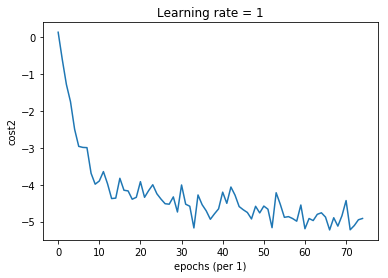

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,64]
costs=[]
dtype=torch.float
continue_flag=0
PATH='./checkpoint_onelayer_entrlowest'
w=[]
z=[]

if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']

else:
    for i in range(len(layer_num)-1):
    
        w.append(torch.randn(layer_num[i],layer_num[i+1], dtype=dtype, requires_grad=True,device="cuda"))

epoches=25
lamda=15
learning_rate=1
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        img=img.reshape(-1,layer_num[0]).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(torch.tanh(torch.mm(img,w[0]).cuda()).cuda())
        for cnt in range(len(w)-1):
            
            z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()).cuda())
            
        grad_list=[]
        
        for cnt in range(len(z)-1):

            
            cost=-emerinal_hsic(z[cnt],img)-lamda*emerinal_hsic(z[cnt],target)
        #print(cost1)
            cost.backward(retain_graph=True)
            print('!')
        #print(w1.cuda().grad)
            with torch.no_grad():
                buf=torch.zeros((w[cnt].shape)).cuda()
                #print(buf.shape)
                buf.copy_(w[cnt].grad)
                
                grad_list.append(buf)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
                w[cnt].grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        entropy=emerinal_hsic(z[-1],img)
        information=lamda*emerinal_hsic(z[-1],target)
        cost=entropy-information
        cost.backward()
        
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1] -= learning_rate * w[-1].grad
            
            for cnt in range(len(w)-1):
                w[cnt] -= learning_rate * grad_list[cnt]
        # Manually zero the gradients after updating weights
            w[-1].grad.zero_()
            
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            costs.append(cost)
            print(i_batch)
            print('cost',cost)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(costs)
plt.ylabel('cost2')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

Populating the interactive namespace from numpy and matplotlib
12.500000000000009 [7]
12.500000764324227 [4]
12.49999979342606 [7]
12.5 [9]
10.997387282887155 [2]
14.437676171648556 [5]
12.491306403731619 [8]
9.563302274792377 [6]
12.340020297651405 [2]
13.650297482668094 [3]
12.500001983367891 [4]
11.000067141954679 [1]
14.000000061972191 [2]
10.66776347046511 [1]
12.500000165259193 [9]
11.650458924293401 [2]
15.276987469511564 [9]
12.499629213467864 [7]
12.494214142240388 [7]
15.499641750070223 [0]
12.5 [3]
12.5 [7]
9.500590157439712 [6]
11.000004338071243 [1]
11.000000846953942 [8]
15.499904504802167 [0]
9.500046088860735 [6]
12.500004338071925 [9]
12.5 [4]
9.5 [6]
12.499992625326582 [9]
15.318527056348433 [5]
12.499997045994423 [4]
12.431094403262664 [8]
9.896072611639358 [6]
14.74811538543742 [8]
15.5 [0]
12.5 [2]
12.495138056742535 [4]
12.500000020657396 [7]
9.5 [6]
12.500000619722062 [9]
11.000002045085171 [8]
12.120985379693014 [2]
12.5 [2]
12.5 [2]
15.5 [0]
14.00070450856336 [

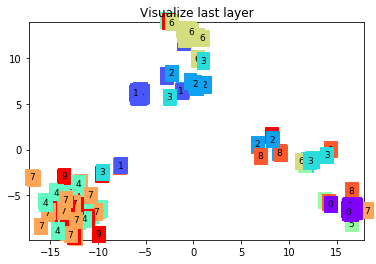

In [14]:
import math
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    print(len(labels))
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
PATH='./checkpoint_onlyonelayer'
checkpoint = torch.load(PATH)
data_tsne_label=np.array(checkpoint['data_tsne_label'])
data_tsne_rp=np.array(checkpoint['z'][0].cpu().data.numpy())
#print(data_tsne_rp[:50,:],data_tsne_label[:50])
for j in range(50):
    num=0
    for i in range(10):
        num=num+math.pow(2,data_tsne_rp[j,i])
    print(num,data_tsne_label[j])

data_tsne_label=data_tsne_label.reshape((-1))
#print(data_tsne_label)
#data_tsne=np.array(data_tsne[:][])
if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
    plot_only = 255
    low_dim_embs = tsne.fit_transform(data_tsne_rp[:plot_only,:])
    labels = data_tsne_label[:plot_only]
    plot_with_labels(low_dim_embs, labels)
plt.ioff()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['entropy', 'dtype', 'rate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


tensor(1.2350, device='cuda:0', grad_fn=<DivBackward0>)
0
cost tensor(-1.0070, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(1.2389, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(1.0031, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.3559, device='cuda:0', grad_fn=<DivBackward0>)
100
cost tensor(-1.0881, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(1.4066, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(1.0374, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1730, device='cuda:0', grad_fn=<DivBackward0>)
200
cost tensor(-1.0186, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(1.1830, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(1.0086, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.3849, device='cuda:0', grad_fn=<DivBackward0>)
0
cost tensor(-0.9349, device='cuda:0', grad_fn=<AddBackward0>)
entr tensor(1.3471, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(0.9727, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1.1649, device='cuda:0', 

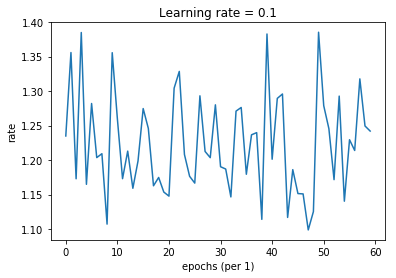

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,10]
costs=[]
dtype=torch.float
continue_flag=1
PATH='./checkpoint_onlyonelayer'
w=[]
z=[]
b=[]
rate_list=[]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']
    b=checkpoint['b']

else:
    for i in range(len(layer_num)-1):
    
        w.append(torch.randn(layer_num[i],layer_num[i+1], dtype=dtype, requires_grad=True,device="cuda"))
        b.append(torch.randn(layer_num[i+1],dtype=dtype, requires_grad=True,device="cuda"))
epoches=20
lamda=5
learning_rate=0.1
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        img=img.reshape(-1,layer_num[0]).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(torch.tanh(torch.mm(img,w[0]).cuda()+b[0]).cuda())
        for cnt in range(len(w)-1):
            
            z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()+b[cnt+1].cuda()).cuda())
            
        grad_listw=[]
        grad_listb=[]
        for cnt in range(len(z)-1):
                
            entropy=emerinal_hsic(z[cnt],img)
                
            
            information=lamda*emerinal_hsic(z[cnt],target)
            cost=-entropy-information
            #0.1*(entropy/information)
        #print(cost1)
            cost.backward(retain_graph=True)
            #print('!')
        #print(w1.cuda().grad)
            with torch.no_grad():
                bufw=torch.zeros((w[cnt].shape)).cuda()
                bufb=torch.zeros((b[cnt].shape)).cuda()
                #print(buf.shape)
                bufw.copy_(w[cnt].grad)
                bufb.copy_(b[cnt].grad)
                grad_listw.append(bufw)
                grad_listb.append(bufb)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
                w[cnt].grad.zero_()
                b[cnt].grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        entropy=emerinal_hsic(z[-1],img)
        information=lamda*emerinal_hsic(z[-1],target)
        rate=emerinal_hsic(z[-1],img)/information
        cost=-entropy-information+1*rate
        #+0.1*(entropy/information)
        
        cost.backward()
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1] -= learning_rate * w[-1].grad
            b[-1] -= learning_rate * b[-1].grad
            
            for cnt in range(len(w)-1):
                w[cnt] -= learning_rate * grad_listw[cnt]
                b[cnt] -= learning_rate * grad_listb[cnt]
        # Manually zero the gradients after updating weights
            w[-1].grad.zero_()
            b[-1].grad.zero_()
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            costs.append(cost)
            print(rate)
            rate_list.append(rate)
            print(i_batch)
            print('cost',cost)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'b': b,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()